Based on the great [work](https://www.kaggle.com/stefanbuenten/mnist-test-with-fastai) of Stefan Langenbach

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
print(torch.cuda.is_available(), torch.backends.cudnn.enabled)

True True


## Inspect data

In [5]:
!ls ../data

dogscats  mnist


In [6]:
PATH = "../data/mnist"
test_df = pd.read_csv(f"{PATH}/test.csv")
train_df = pd.read_csv(f"{PATH}/train.csv")

In [7]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(train_df.shape, test_df.shape)

(42000, 785) (28000, 784)


## Prepare data

In [10]:
# create validation dataset
valid_df = train_df.sample(frac=0.00002, random_state=42)
valid_df.shape

(1, 785)

In [11]:
# drop validation data from train dataset
train_df = train_df.drop(valid_df.index)
train_df.shape

(41999, 785)

In [12]:
# separate labels from data
Y_train = train_df['label']
Y_valid = valid_df['label']
X_train = train_df.drop('label', axis=1)
X_valid = valid_df.drop('label', axis=1)

In [13]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(41999, 784) (41999,)
(1, 784) (1,)


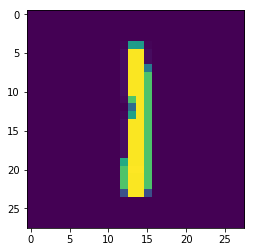

In [14]:
# visualize a digit
img = X_train.iloc[2, :].values.reshape(28,28)
plt.imshow(img)

## Preprocessing

In [15]:
def reshape_img(matrix):
    """
    Reshape an existing 2D pandas.dataframe into 3D-numpy.ndarray
    """
    try:
        return matrix.values.reshape(-1, 28, 28)
    except AttributeError as e:
        print(e)

In [16]:
def add_color_channel(matrix):
    """
    Add missing color channels to previously reshaped image
    """
    matrix = np.stack((matrix, ) *3, axis = -1)
    return matrix

In [17]:
def convert_ndarray(matrix):
    """
    Convert pandas.series into numpy.ndarray
    """
    try:
        return matrix.values.flatten()
    except AttributeError as e:
        print(e)

In [18]:
# reshape data and add color channels
X_train = reshape_img(X_train)
X_train = add_color_channel(X_train)
X_valid = reshape_img(X_valid)
X_valid = add_color_channel(X_valid)
test_df = reshape_img(test_df)
test_df = add_color_channel(test_df)

In [19]:
# convert y_train and y_valid into proper numpy.ndarray
Y_train = convert_ndarray(Y_train)
Y_valid = convert_ndarray(Y_valid)

In [20]:
# run sanity checks
preprocessed_data = [X_train, Y_train, X_valid, Y_valid, test_df]
print([e.shape for e in preprocessed_data])
print([type(e) for e in preprocessed_data])

[(41999, 28, 28, 3), (41999,), (1, 28, 28, 3), (1,), (28000, 28, 28, 3)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


## Model

In [21]:
# define architecture
arch = resnext50
sz = 28
bs = 64
classes = np.unique(Y_train)

In [22]:
data = ImageClassifierData.from_arrays(path='tmp', 
                                       trn=(X_train, Y_train),
                                       val=(X_valid, Y_valid),
                                       bs=bs,
                                       classes=Y_train,
                                       test=test_df,
                                       tfms=tfms_from_model(arch, sz))

In [23]:
# run learner with precompute enabled
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1/1 [00:00<00:00, 54.42it/s]


In [24]:
# find optimal learning rate
lrf = learn.lr_find()

 79%|███████▉  | 521/657 [00:09<00:03, 36.31it/s, loss=1.11] 


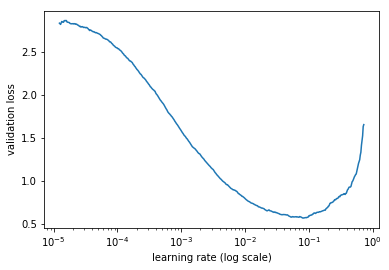

In [25]:
# plot loss vs. learning rate
learn.sched.plot()

In [26]:
lr = 1e-2

#### 3) Train last layer from precomputed activations for 1-2 epochs

In [27]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.319173   0.019053   1.0       
    1      0.270764   0.012721   1.0                         



[array([0.01272]), 1.0]

#### 5) Unfreeze all layers

In [28]:
learn.precompute=False
learn.unfreeze()

#### 6) Set earlier layers to 3x-10x lower learning rate than next higher layer

In [29]:
lr = np.array([0.001, 0.0075, 0.01])

#### 8) Train full network with cycle_mult=2 until over-fitting

In [30]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.096596   0.00243    1.0       
    1      0.061206   0.001431   1.0                          
    2      0.032748   0.000642   1.0                          
    3      0.0383     0.000131   1.0                          
    4      0.02014    0.000183   1.0                          
    5      0.0117     8.7e-05    1.0                           
    6      0.011446   0.000102   1.0                           



[array([0.0001]), 1.0]

#### Add test time augmentation

In [31]:
# get accuracy for validation set
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

1.0

In [32]:
# predict on test set
%time log_preds_test, y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test), 0)
probs_test.shape

CPU times: user 1min 52s, sys: 14.1 s, total: 2min 6s
Wall time: 1min 36s


(28000, 10)

## Submission

In [33]:
# create dataframe from probabilities
df = pd.DataFrame(probs_test)

In [34]:
# increase index by 1 to obtain proper ImageIDs
df.index += 1

In [35]:
# create new colum containing label with highest probability for each digit
df = df.assign(Label = df.values.argmax(axis=1))

In [36]:
# replicate index as dedicated ImageID column necessary for submission
df = df.assign(ImageId = df.index.values)

In [37]:
# drop individual probabilites
df = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)

In [38]:
# reorder columns for submission
df = df[["ImageId", "Label"]]

In [39]:
# run sanity checks
df.head()


,ImageId,Label
1,1,2
2,2,0
3,3,9
4,4,0
5,5,3


In [40]:
# ...
df.tail()

,ImageId,Label
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9
28000,28000,2


In [41]:
# ...
df.shape

(28000, 2)

In [42]:
# write dataframe to CSV
comp_name = "digit_recognizer"
version = 'v5'
df.to_csv(f"sub_{comp_name}_{arch.__name__}_{version}.csv", index=False)

## Analyze results

In [45]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[811   0   0   1   0   0   4   0   0   0]
 [  0 907   0   0   0   0   1   1   0   0]
 [  1   3 838   1   0   0   0   2   1   0]
 [  0   0   0 933   0   2   0   1   1   0]
 [  0   1   0   0 829   0   2   2   1   4]
 [  0   0   0   1   0 699   1   0   1   0]
 [  0   0   0   0   0   1 784   0   0   0]
 [  0   1   0   0   1   0   0 891   0   0]
 [  0   0   0   1   1   3   1   1 826   2]
 [  0   1   1   1   1   1   0   0   2 831]]


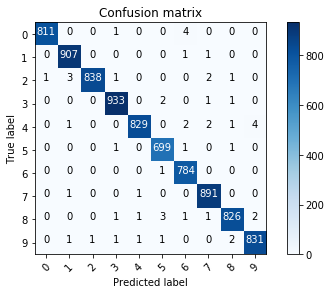

In [72]:
plot_confusion_matrix(cm, classes)

In [142]:
def load_img_id(idx):
    #print(idx)
    img = X_valid[idx].reshape(28,28,3)
    return img

def plot_val_with_title(idxs, title):
    print(idxs)
    imgs = [load_img_id(x) for x in idxs]
    title_probs = [(preds[x], y[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=4, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [145]:
# count incorrect predictions
incorrect_digits = np.where(preds != y)[0]
len(incorrect_digits)

51

[  64   65   71  139  445  666  881 1182 1631 1889 1943 1991 2445 2622 2638 2915 3073 3269 3375 3583 3895
 4003 4007 4187 4293 4397 4521 4534 4564 4577 4622 4731 4780 5091 5123 5161 5442 5448 5609 5958 5995 6008
 6319 6384 6599 7264 7641 7802 8242 8267 8368]
Incorrect digits


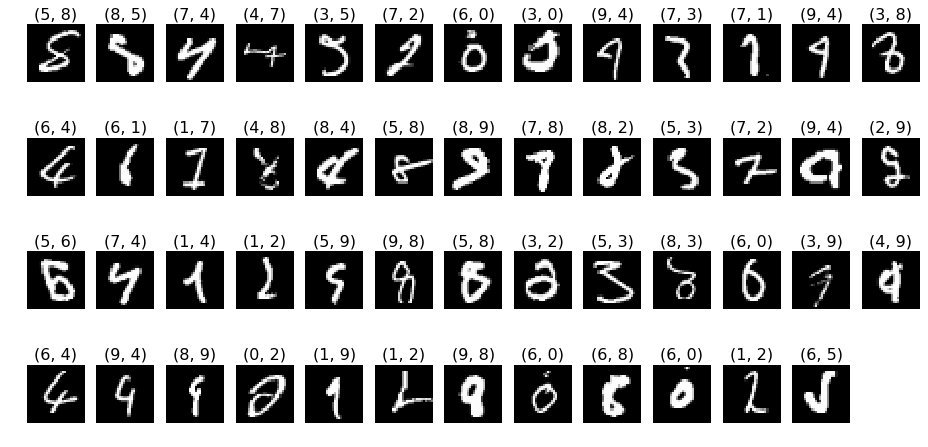

In [146]:
# visualize incorrect predictions
plot_val_with_title(incorrect_digits, "Incorrect digits")